In [418]:
import io
import requests
import scipy
import pandas as pd
import numpy as np
import pandas_profiling
from pandas_profiling import ProfileReport
import os
import sklearn as sk
import re
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.cluster import KMeans
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from imblearn.over_sampling import SMOTE
from sklearn import svm
from sklearn import metrics as metrics_sk
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import precision_recall_curve
from scipy.stats import ks_2samp
from scipy.stats import chisquare
from scipy.stats import kruskal
from scipy.stats import chi2_contingency
import numpy.ma as ma
from IPython.display import Image, display_svg, SVG
import joblib

In [232]:
from keras import layers, Sequential
from keras.layers import Input, Add, Dropout, Dense, Activation, ZeroPadding1D, ZeroPadding2D, BatchNormalization, Flatten, Conv1D, AveragePooling1D, MaxPooling1D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from keras import metrics
from keras import optimizers
from keras import regularizers
import pydot
from tensorflow.keras import regularizers
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
%matplotlib inline
import tensorflow as tf
import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

Using TensorFlow backend.
C:\Anaconda3\envs\benedito_deep\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Anaconda3\envs\benedito_deep\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Anaconda3\envs\benedito_deep\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Anaconda3\envs\benedito_deep\lib\site-packages\tensorflo

In [234]:
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects

# ------------------------------------------------------------
# needs to be defined as activation class otherwise error
# AttributeError: 'Activation' object has no attribute '__name__'    
class Swish(Activation):
    
    def __init__(self, activation, **kwargs):
        super(Swish, self).__init__(activation, **kwargs)
        self.__name__ = 'swish'

def swish(x):
    return (K.sigmoid(x) * x)

get_custom_objects().update({'swish': Swish(swish)})

In [158]:
train_url = 'https://raw.githubusercontent.com/bfaustinoni/adult_dataset/master/adult_dataset/Data/adult_data.csv?token=APAMAPNANNE4QLBQK3UXLA27ZDWCC'
test_url = 'https://raw.githubusercontent.com/bfaustinoni/adult_dataset/master/adult_dataset/Data/adult_test.csv?token=APAMAPM6X5SCBKIB5QRYX2K7ZDWD6'
train=requests.get(train_url).content
test = requests.get(test_url).content

In [159]:
columns = ['age','workclass','fnlwgt','education','education-num','marital-status','occupation','relationship','race',
          'sex','capital-gain','capital-loss','hours-per-week','native-country', 'target']
train_data = pd.read_table(io.BytesIO(train), sep =';')
test_data = pd.read_table(io.BytesIO(test), sep =';')


In [160]:
train_data.columns = columns
test_data.columns = columns

## In our Database, the missing values are set as '?'. Let's change 'em for python Nones in order to have a clearer overview

In [161]:
train_data.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country    object
target            object
dtype: object

In [162]:
categorical = ['workclass', 'education', 'marital-status', 'occupation',
              'relationship', 'race', 'sex', 'native-country']
numerical = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

In [163]:
for feat in list(train_data.columns):
    if feat in categorical:
        train_data.loc[train_data[feat].str.strip()=='?', feat]=None
        test_data.loc[test_data[feat].str.strip()=='?', feat]=None
    else:
        test_data.loc[test_data[feat].isna(), feat]=None

## First impressions: Features' Profiling

In [164]:
train_data['target'] = train_data.target.str.strip()
test_data['target'] = test_data.target.str.strip()
full_data = pd.concat([train_data, test_data], axis = 0)

In [165]:
profile = ProfileReport(full_data,title='Adult Dataset',minimal = True, html={'style':{'full_width':True}})

### $\rightarrow$ Note that we also check on the test dataset in order to have a 360º vision of our data.

In [166]:
profile

## Ok, we have some missing data and some zero-inflated variables. Also, our target variable is codified in different manners between the train and test sets. Before addressing these situations, let's make a bivariate data analysis with the the informations that we already have.

In [167]:
train_data['target']=np.where((train_data['target']=='>50K')|(train_data['target']=='>50K.'), 1, 0)
test_data['target']=np.where((test_data['target']=='>50K')|(test_data['target']=='>50K.'), 1, 0)
full_data['target']=np.where((full_data['target']=='>50K')|(full_data['target']=='>50K.'), 1, 0)

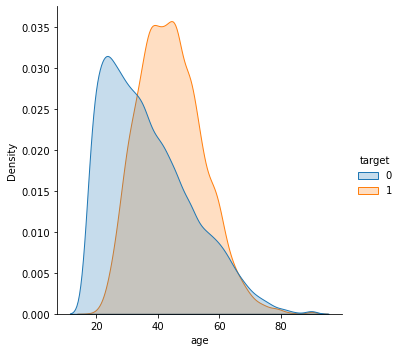

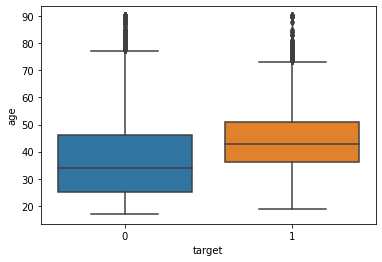

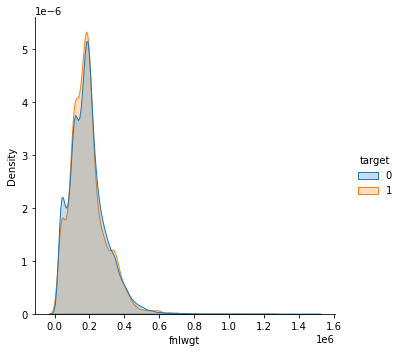

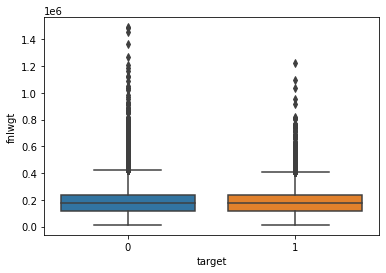

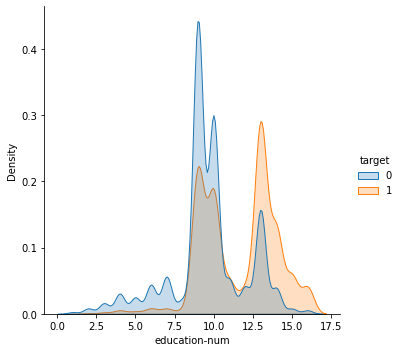

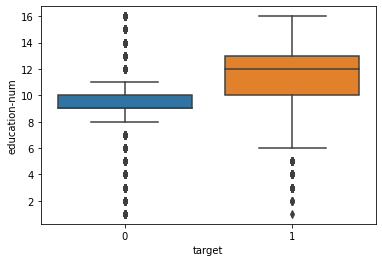

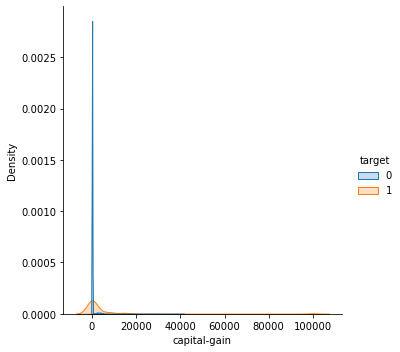

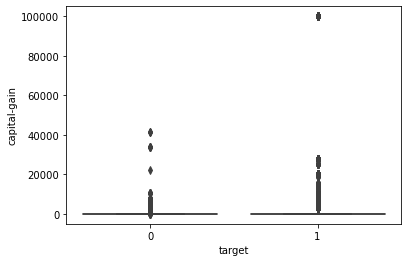

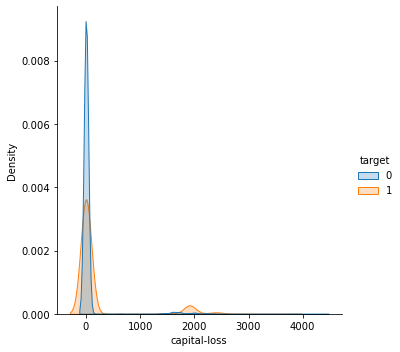

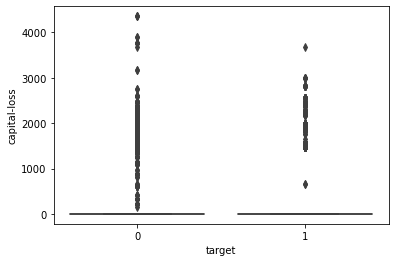

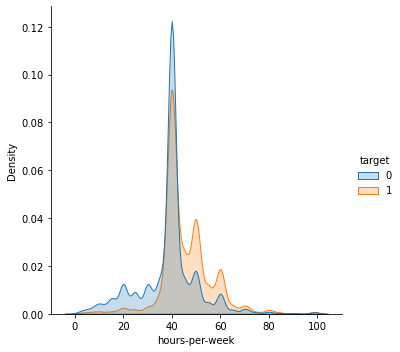

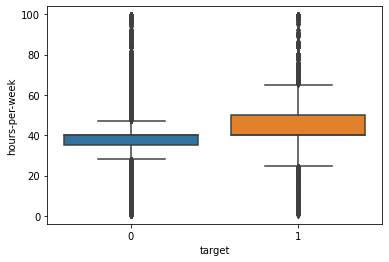

In [168]:
for feat in numerical:
    sns.displot(train_data, x=feat, hue='target', kind = 'kde', fill = True, common_norm = False)
    plt.show()
    sns.boxplot(x='target', y=feat, data=full_data)
    plt.show()

## Our numerical variables are plenty of outliers $\rightarrow$ One more issue to be addressed.

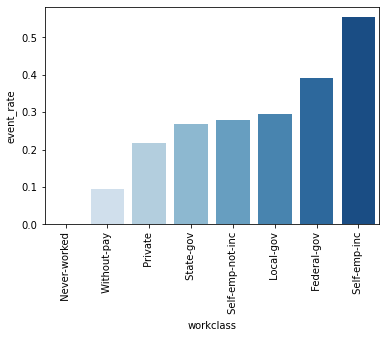

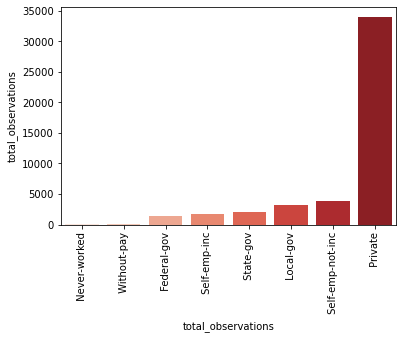

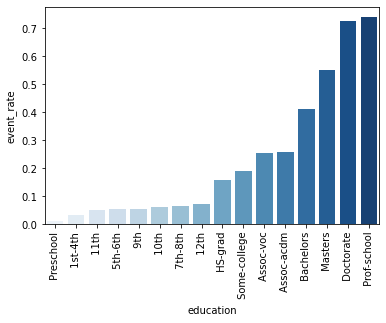

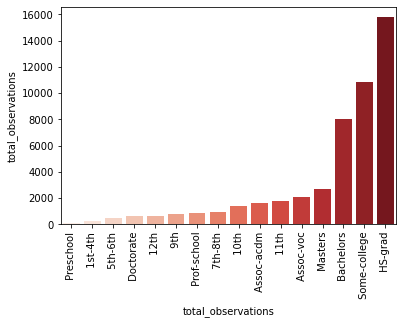

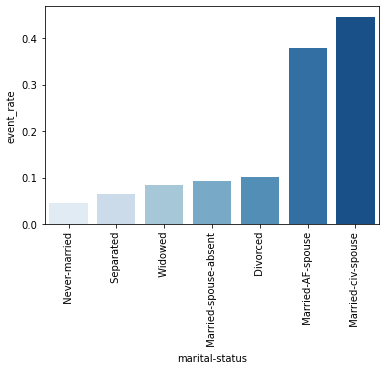

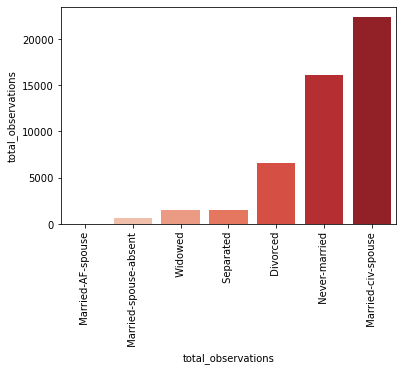

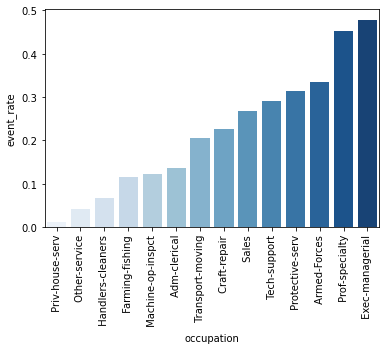

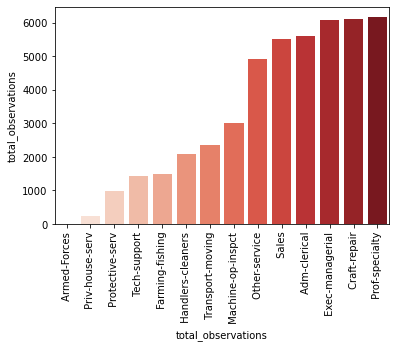

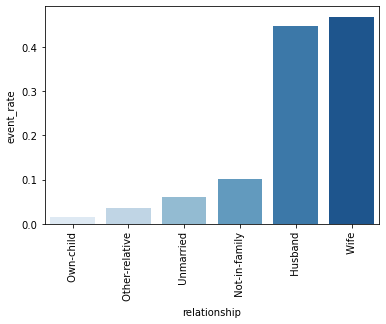

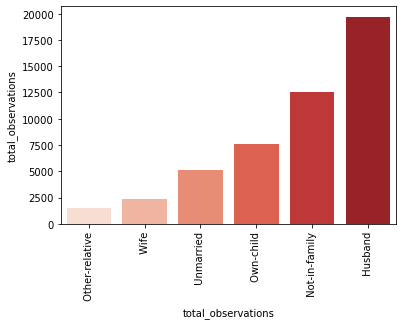

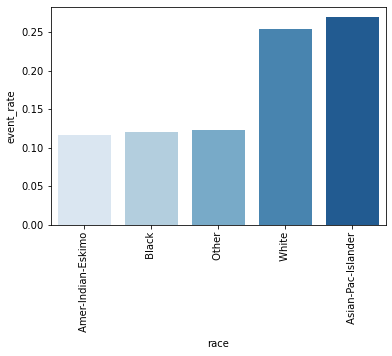

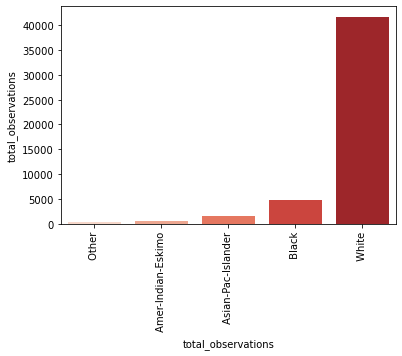

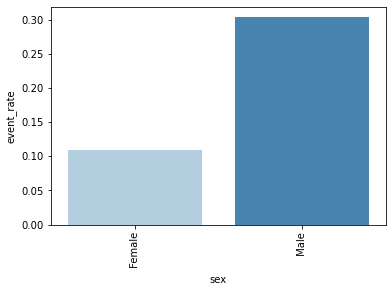

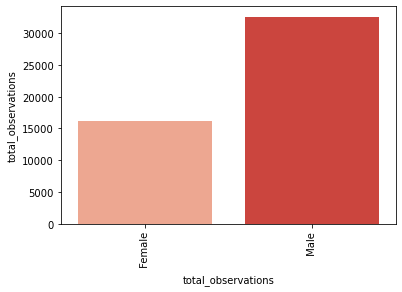

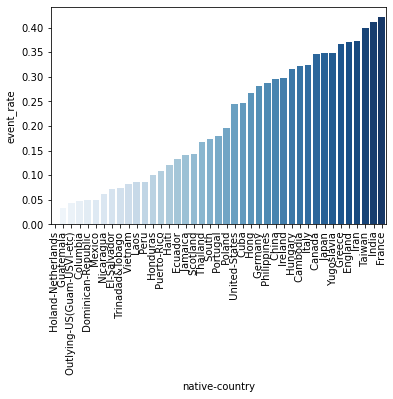

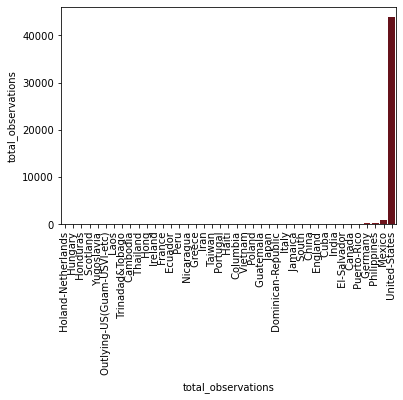

In [93]:
for feat in categorical:
    data_cross = pd.crosstab(full_data[feat], full_data['target'], normalize = 'index').reset_index()
    data_qtd = pd.DataFrame(full_data.groupby([feat])['target'].count()).reset_index()

    
    data_cross.columns = [feat, 'n_event_rate', 'event_rate']
    data_qtd.columns = [feat, 'total_observations']
    
    data_cross = data_cross.sort_values(['event_rate']).reset_index(drop=True)
    data_qtd = data_qtd.sort_values(['total_observations']).reset_index(drop=True)
        
    #plt.subplot(1,2,1)
    data_cross_plot=sns.barplot(x=data_cross[feat],y=data_cross.iloc[:,2], order = data_cross.sort_values('event_rate')[feat], palette = 'Blues')
    data_cross_plot.set_xticklabels(labels = data_cross[feat].unique(),rotation=90)
    plt.show()
    #plt.subplot(1,2,2)
    data_qtd_plot=sns.barplot(x=data_qtd[feat],y=data_qtd.iloc[:,1], order = data_qtd.sort_values('total_observations')[feat], palette = 'Reds')
    data_qtd_plot.set_xlabel('total_observations')
    data_qtd_plot.set_xticklabels(labels = data_qtd[feat].unique(),rotation=90)
    
    plt.show()
#data_cross_plot.set_xticklabels('education',rotation=45)

# Feature engineering - I

## Categorical features' WOE

In [169]:
def woe(df, feat, target):
    levels = {}
    df_feat = pd.DataFrame()
    df_feat['event_rate'] = df.groupby([feat])[target[0]].sum()/df.groupby([feat])[target[0]].count()
    df_feat['n_event_rate'] = 1-df_feat['event_rate']
    df_feat['woe'] = np.log((df_feat['event_rate']+0.0000001)/(df_feat['n_event_rate']+0.0000001))
    levels = {level: df_feat.loc[level,'woe'] for level in df_feat.index}
    return levels

In [170]:
for feat in categorical:
    levels = woe(train_data, feat, ['target'])
    train_data.loc[~train_data.loc[:,feat].isna(),'woe_'+feat] = [levels[level] for level in train_data.loc[~train_data.loc[:,feat].isna(),feat]]
    train_data = train_data.drop([feat], axis = 1)
    test_data.loc[~test_data.loc[:,feat].isna(),'woe_'+feat] = [levels[level] for level in test_data.loc[~test_data.loc[:,feat].isna(),feat]]
    test_data = test_data.drop([feat], axis = 1)

## Missing values' imputation

In [171]:
train_data['missing_rate'] = train_data.isnull().sum(axis=1)/train_data.shape[1]
test_data['missing_rate'] = test_data.isnull().sum(axis=1)/test_data.shape[1]

In [172]:
def select_feats(df, target, categorical, numerical):
    feats = df.columns
    selected = {}
    feats=feats.drop([target])
    for feat in feats:
        if((target in categorical)&(feat in categorical)):
            contingency = pd.crosstab(df[target], df[feat])
            pvalue = chi2_contingency(contingency)[1]
            if(pvalue < 0.05):
                selected[feat]=pvalue
        
        if((target in categorical)&(feat in numerical)):
            df_ = df[[target, feat]]
            groups = {}
            for grp in df_[target].unique():
                groups[grp] = df_[feat][df_[target]==grp].values
            args = groups.values()
            pvalue = scipy.stats.kruskal(*args)[1]
            if(pvalue<0.05):
                selected[feat]=pvalue
        
        if((target in numerical)&(feat in categorical)):
            df_ = df[[target, feat]]
            groups = {}
            for grp in df_[feat].unique():
                groups[grp] = df_[target][df_[feat]==grp].values
            args = groups.values()
            pvalue = scipy.stats.kruskal(*args)[1]
            if(pvalue<0.05):
                selected[feat]=pvalue
        
        if((target in numerical)&(feat in numerical)):
            correlation = np.abs(np.corrcoef(ma.masked_invalid(df[target]),ma.masked_invalid(df[feat])))[0][1]
            if(correlation>0.5):
                selected[feat]=correlation
    return selected

In [173]:
df = train_data.drop(['target', 'missing_rate'], axis = 1)
df_test = test_data.drop(['target', 'missing_rate'], axis = 1)

In [174]:
nulls = {feat: df[feat].isna().sum()/df[feat].shape[0] for feat in list(df.columns) if df[feat].isna().sum()>0}
nulls = sorted(nulls.items(), key=lambda x: x[1])
lista_nulls = [nulls[i][0] for i in range(len(nulls))]

In [175]:
lista_nulls

['woe_native-country', 'woe_workclass', 'woe_occupation']

In [176]:
categorical = ['woe_'+feat for feat in categorical]

## Now that we've used WOE we can treat all variables in a numerical fashion. It makes the imputation easier using decision tree regressors.

In [177]:
def tree_imputer(df, df_test, target, categorical, numerical, selected, sample_rate):
    imputer = DecisionTreeRegressor(max_depth = 2, min_samples_split=250, min_samples_leaf = 250, criterion = 'mae', min_impurity_decrease=1e-07, random_state=11235)
    sample = df[~(df[selected+target].isna().any(1))].sample(int(sample_rate*df[~df[selected+target].isna().any(1)].shape[0]))
    sample = sample[~sample.isna().any(1)]
    X = sample.drop([target[0]], axis = 1)
    X = X[~X.isna().any(1)]
    X.fillna(0, inplace=True)
    #X = X[selected]
    y = sample[target[0]]
    imputer_ = imputer.fit(X, y)
    aux = df.loc[df[target[0]].isnull(), X.columns].copy()#.fillna(0, inplace=True)
    aux.fillna(0, inplace =True)
    df.loc[df[target[0]].isna(),target[0]] = imputer_.predict(aux)
    
    aux_test = df_test.loc[df_test[target[0]].isnull(), X.columns].copy()#.fillna(0, inplace=True)
    aux_test.fillna(0, inplace =True)
    df_test.loc[df_test[target[0]].isna(),target[0]] = imputer_.predict(aux_test)
    return df, df_test

In [178]:
sample_rate = 0.5

for feat in lista_nulls:
    target = [feat]
    selected = select_feats(df, feat, categorical, numerical)
    selected = list(selected.keys())
    train_data, test_data = tree_imputer(train_data, test_data, target, selected, numerical, categorical, sample_rate)
    print("Working on feature: ", feat)

Working on feature:  woe_native-country
Working on feature:  woe_workclass
Working on feature:  woe_occupation


## Checking whether our imputation resulted in a monotonic WOE on the training dataset, respect to the target variable

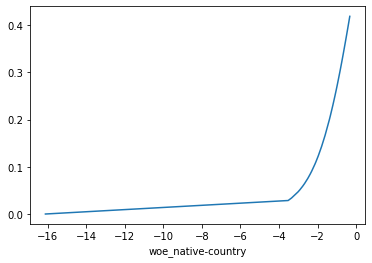

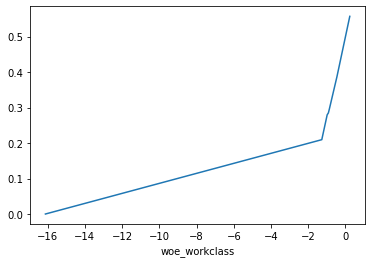

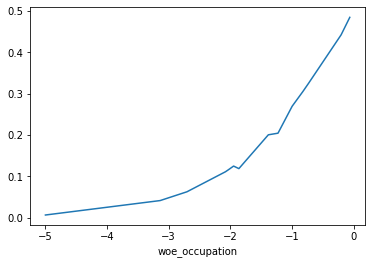

In [179]:
for feat in lista_nulls:

    fig = plt.figure()
    fig = train_data.groupby([feat])['target'].mean().plot()

## And on the test set:

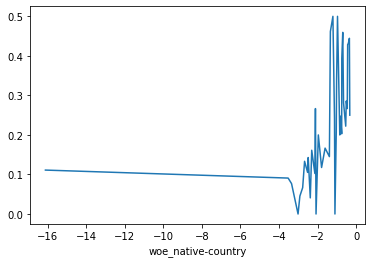

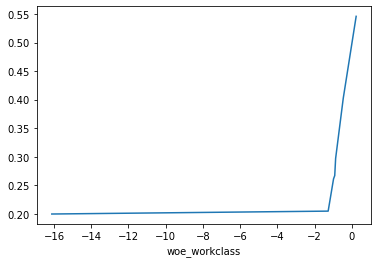

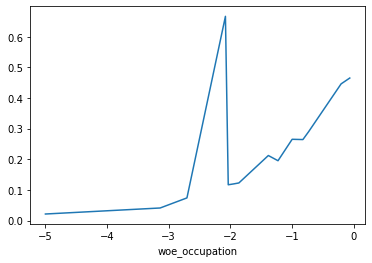

In [180]:
for feat in lista_nulls:

    fig = plt.figure()
    fig = test_data.groupby([feat])['target'].mean().plot()

###### ... God knows I've tried

## Working on zero-inflated variables

### We'll try two approaches, with decision trees and inverse-hyperbolic sine transformation

In [181]:
non_monotonic = ['capital-gain', 'capital-loss']

In [182]:
np.random.seed(11235)
index = np.random.randint(train_data.shape[0], size = train_data.shape[0])
train_data.loc[:,'index'] = index
train_data.set_index('index',inplace = True)
sample = train_data.sample(2000, random_state = 11235)
valid = train_data[~train_data.index.isin(sample.index)].sample(1000, random_state = 11235)
X_train = sample.drop(['target'], axis =1)
y_train = sample['target']
X_valid = valid.drop(['target'], axis = 1)
y_valid = valid['target']


In [183]:
def evaluate_depth(X_train, X_valid, y_train, y_valid, non_monotonic):
    result = {}
    final_depth = {}
    
    depth = [2, 3, 4, 5, 6, 7, 8, 9, 10]
    scaler = StandardScaler()
    for feat in non_monotonic:
        feat_dict ={}
        for i in depth:    
            model = DecisionTreeClassifier(max_depth = i, min_samples_split=100, min_samples_leaf = 100, min_impurity_decrease=1e-07, random_state=11235)
            X_feat_train = scaler.fit_transform(np.array(X_train[feat]).reshape(-1,1))
            X_feat_valid = scaler.transform(np.array(X_valid[feat]).reshape(-1, 1))
            model.fit(X_feat_train, y_train)
            score = model.predict_proba(X_feat_valid)[:,1]
            roc = metrics_sk.roc_auc_score(y_valid,score)
            feat_dict[i]=roc
        result[feat] = feat_dict#{'depth': depth_, 'AUC': metric}
        #final_depth[feat]=max(result[feat], key = lambda k: result[feat][k])
    return result#, final_depth

def choose_opt_depth(result):
    opt_choice={}
    for feat in resultado.keys():
        opt_choice[feat]=max(result[feat], key = result[feat].get)
    return opt_choice

In [184]:
resultado = evaluate_depth(X_train, X_valid, y_train, y_valid, non_monotonic)
otimo = choose_opt_depth(resultado)

In [185]:
def monotonic_transform(X_train, y_train, non_monotonic, df, df_test, opt_choice):
    for feat in non_monotonic:
        #scaler = StandardScaler()
        model = DecisionTreeClassifier(max_depth = opt_choice[feat], min_samples_split=100, min_samples_leaf = 100, min_impurity_decrease=1e-07, random_state=11235)
        #X_feat_train = scaler.fit_transform(np.array(X_train[feat]).reshape(-1,1))
        X_feat_train = np.array(X_train[feat]).reshape(-1,1)
        #df[feat] = scaler.transform(np.array(df[feat]).reshape(-1,1))
        model.fit(X_feat_train, y_train)
        df[feat+'_monotonic'] = model.predict_proba(np.array(df[feat]).reshape(-1,1))[:,1]
        #df=df.drop([feat], axis = 1)
        
        df_test[feat+'_monotonic'] = model.predict_proba(np.array(df_test[feat]).reshape(-1,1))[:,1]
        #df_test=df_test.drop([feat], axis = 1)

    return df, df_test

In [186]:
train_data_transformed = train_data.copy()

In [187]:
train_data_transformed, test_data_transformed  = monotonic_transform(X_train, y_train, non_monotonic, train_data, test_data, otimo)

## Plotting to verify whether the monotonic transformation worked

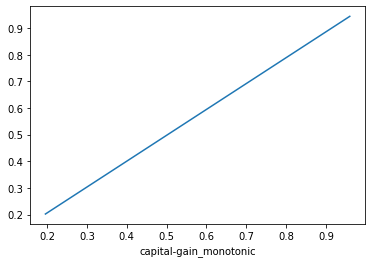

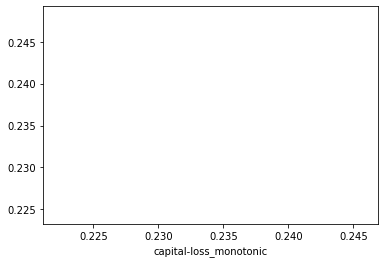

In [188]:
for feat in non_monotonic:

    fig = plt.figure()
    fig = test_data_transformed.groupby([feat+'_monotonic'])['target'].mean().plot()

## Let's try also de Inverse-Hyperbolic Sine Transformation

In [189]:
def transform_y(y, theta):
    return np.log((theta*y +((((theta*y)**2)+1)**0.5)))/theta

def log_likelihood(theta, x, y):
    n, p = x.shape
    lnjacobi = -0.5*np.log(1+(theta*y)**2).sum()
    trans_y = transform_y(y, theta)
    xtxinv = np.linalg.inv(np.dot(x.T, x))
    imxxtxinvxt = np.subtract(np.identity(n), np.dot(np.dot(x, xtxinv), x.T))
    rss = np.dot(np.dot(trans_y.T, imxxtxinvxt), trans_y)
    return -(n/2.0)*np.log(rss) + lnjacobi

def choose_opt_theta(x, y, feat_selected):
    potential_thetas = np.linspace(0.001, 2, 2000)
    x=x[feat_selected]
    likelihoods = np.array([log_likelihood(theta, x, y) for theta in potential_thetas])
    opt_theta = potential_thetas[np.argmax(likelihoods)]
    return opt_theta

In [190]:
zero_inflated = ['capital-gain', 'capital-loss']

In [191]:
zeros = {feat: (train_data[feat]==0).sum()/(train_data[feat]).shape[0] for feat in zero_inflated}
zeros = sorted(zeros.items(), key=lambda x: x[1])
lista_zeros = [zeros[i][0] for i in range(len(zeros))]
lista_zeros

['capital-gain', 'capital-loss']

In [192]:
data_aux = train_data_transformed.drop(['target'], axis = 1)

In [193]:
def inv_sinh_transform_theta_selection(df, lista_zeros):
    feat_theta = {}
    x = df
    for y in lista_zeros:
        selected = select_feats(x, y, categorical, numerical)
        feat_selected = list(selected.keys())
        opt_theta = choose_opt_theta(x, np.array(x[y]), feat_selected)
        feat_theta[y]=opt_theta
        print("working on feat: ", y, ": ", opt_theta)
    return feat_theta

In [194]:
df_sample = data_aux.sample(3500)

In [195]:
feat_theta_ = inv_sinh_transform_theta_selection(df_sample, lista_zeros)

working on feat:  capital-gain :  2.0
working on feat:  capital-loss :  2.0


In [196]:
feat_theta_
#{'capital-gain': 2.0, 'capital-loss': 2.0}

{'capital-gain': 2.0, 'capital-loss': 2.0}

In [197]:
for feat in list(feat_theta_.keys()):
    train_data_transformed[feat+'_transformed']=transform_y(train_data_transformed[feat], feat_theta_[feat])
    test_data_transformed[feat+'_transformed']=transform_y(test_data_transformed[feat], feat_theta_[feat])
    

### Dealing with outliers: imputing the inferior and superior limits

In [198]:
for feat in numerical:
    l_inf = np.quantile(train_data_transformed[feat],0.025) 
    l_sup = np.quantile(train_data_transformed[feat],0.975)
    train_data_transformed.loc[train_data_transformed[feat]<l_inf,feat] = l_inf
    train_data_transformed.loc[train_data_transformed[feat]>l_sup,feat] = l_sup   
    test_data_transformed.loc[test_data_transformed[feat]<l_inf,feat] = l_inf
    test_data_transformed.loc[test_data_transformed[feat]>l_sup,feat] = l_sup  

In [199]:
train_data_transformed.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,target,woe_workclass,woe_education,woe_marital-status,woe_occupation,woe_relationship,woe_race,woe_sex,woe_native-country,missing_rate,capital-gain_monotonic,capital-loss_monotonic,capital-gain_transformed,capital-loss_transformed
index,,,,,,,,,,,,,,,,,,,,
32159,50.0,83311.0,13.0,0.0,0.0,13.0,0,-0.920150,-0.344033,-0.213413,-0.063967,-0.206445,-1.067551,-0.820061,-1.120906,0.0,0.195789,0.234,0.0,0.0
734,38.0,215646.0,9.0,0.0,0.0,40.0,0,-1.273417,-1.661888,-2.151309,-2.703387,-2.163430,-1.067551,-0.820061,-1.120906,0.0,0.195789,0.234,0.0,0.0
15477,53.0,234721.0,7.0,0.0,0.0,40.0,0,-1.273417,-2.922263,-0.213413,-2.703387,-0.206445,-1.956192,-0.820061,-1.120906,0.0,0.195789,0.234,0.0,0.0
18426,28.0,338409.0,13.0,0.0,0.0,40.0,0,-1.273417,-0.344033,-0.213413,-0.204575,-0.099572,-1.956192,-2.096262,-1.029619,0.0,0.195789,0.234,0.0,0.0
29329,37.0,284582.0,14.0,0.0,0.0,40.0,0,-1.273417,0.227323,-0.213413,-0.063967,-0.099572,-1.067551,-2.096262,-1.120906,0.0,0.195789,0.234,0.0,0.0


In [200]:
scaler = StandardScaler()

In [201]:
train_data_transformed[numerical] = scaler.fit_transform(train_data_transformed[numerical])
test_data_transformed[numerical] = scaler.transform(test_data_transformed[numerical])

## Feature Egineering II - Creating some variables

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


[(2, 0.2933849652203429),
 (3, 0.3464576462199474),
 (4, 0.3476495388832361),
 (5, 0.35769206576310264),
 (6, 0.3642736981645211),
 (7, 0.38083675815227114),
 (8, 0.35939929942877236),
 (9, 0.4170643790340324),
 (10, 0.4130059835614748),
 (11, 0.41743745169448776),
 (12, 0.4175345032386071),
 (13, 0.41430032057961946),
 (14, 0.41368747084531216),
 (15, 0.4246166797089498),
 (16, 0.42399949842418766),
 (17, 0.4064940093507647),
 (18, 0.4233313503801088),
 (19, 0.4049083414625255),
 (20, 0.4072361534877974),
 (21, 0.4151999872062885),
 (22, 0.39338784199819227),
 (23, 0.42494129370509154),
 (24, 0.4093909008958939),
 (25, 0.40172478332658934),
 (26, 0.40954933491556483),
 (27, 0.4197767773440374),
 (28, 0.409222598273405),
 (29, 0.3931447134781228)]

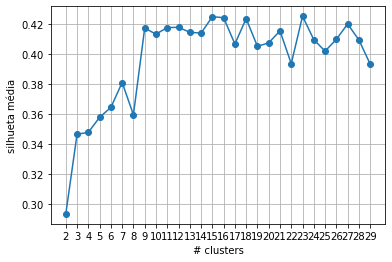

In [205]:
##silhueta:
np.random.seed(11235)
silhueta = []
n_cluster = []
sample_train_data_transformed = train_data_transformed[['age','education-num','woe_sex']].sample(10000)


for i in range(2, 30): ###a silhueta é calculada para n>=2 clusters
    kmeans = KMeans(n_clusters = i)
    kmeans.fit(sample_train_data_transformed)
    print(i)
    
    n_cluster.append(i)
    silhueta.append(silhouette_score(sample_train_data_transformed, kmeans.predict(sample_train_data_transformed)))
    
    
plt.plot(n_cluster, silhueta, 'o-')
plt.xlabel('# clusters')
# plt.scatter(8, sse[7], s=1000, marker='x')
plt.ylabel('silhueta média')
plt.grid()
plt.xticks(n_cluster)


list(zip(n_cluster, silhueta)) ###melhor numero de clusters é 5

In [206]:
kmeans = KMeans(n_clusters = 23) ###
kmeans_ = kmeans.fit(train_data_transformed[['age','education-num','woe_sex']])

In [208]:
dados_kmeans = train_data_transformed[['age','education-num','woe_sex']]
dados_kmeans_test = test_data_transformed[['age','education-num','woe_sex']]

In [209]:
train_data_transformed.loc[:,'demographical_cluster'] = kmeans_.predict(dados_kmeans)
test_data_transformed.loc[:,'demographical_cluster'] = kmeans_.predict(dados_kmeans_test)

In [214]:
train_data_transformed.groupby(['demographical_cluster'])['target'].mean()

demographical_cluster
0     0.323171
1     0.086022
2     0.694860
3     0.025213
4     0.257161
5     0.081664
6     0.088865
7     0.112903
8     0.023369
9     0.144006
10    0.342451
11    0.328544
12    0.540487
13    0.014373
14    0.226797
15    0.609644
16    0.122970
17    0.032538
18    0.756550
19    0.173933
20    0.003082
21    0.308351
22    0.442911
Name: target, dtype: float64

In [215]:
def woe_demographical_cluster(x):
    if x == 0:
        return np.log((1-0.323171)/0.323171)
    if x == 1:
        return np.log((1-0.086022)/0.086022)
    if x == 2:
        return np.log((1-0.694860)/0.694860)
    if x == 3:
        return np.log((1-0.025213)/0.025213)
    if x == 4:
        return np.log((1-0.257161)/0.257161)
    if x == 5:
        return np.log((1-0.081664)/0.081664)
    if x == 6:
        return np.log((1-0.088865)/0.088865)
    if x == 7:
        return np.log((1-0.112903)/0.112903)
    if x == 8:
        return np.log((1-0.023369)/0.023369)
    if x == 9:
        return np.log((1-0.144006)/0.144006)
    if x == 10:
        return np.log((1-0.342451)/0.342451)
    if x == 11:
        return np.log((1-0.328544)/0.328544)
    if x == 12:
        return np.log((1-0.540487)/0.540487)
    if x == 13:
        return np.log((1-0.014373)/0.014373)
    if x == 14:
        return np.log((1-0.226797)/0.226797)
    if x == 15:
        return np.log((1-0.609644)/0.609644)
    if x == 16:
        return np.log((1-0.122970)/0.122970)
    if x == 17:
        return np.log((1-0.032538)/0.032538)
    if x == 18:
        return np.log((1-0.756550)/0.756550)
    if x == 19:
        return np.log((1-0.173933)/0.173933)
    if x == 20:
        return np.log((1-0.003082)/0.003082)
    if x == 21:
        return np.log((1-0.308351)/0.308351)
    if x == 22:
        return np.log((1-0.442911)/0.442911)
    else:
        return 0   

In [216]:
train_data_transformed.loc[:,'woe_demographical_cluster'] = train_data_transformed.demographical_cluster.apply(woe_demographical_cluster)
test_data_transformed.loc[:,'woe_demographical_cluster'] = test_data_transformed.demographical_cluster.apply(woe_demographical_cluster)

In [217]:
train_data_transformed=train_data_transformed.drop(['demographical_cluster'], axis =1)
test_data_transformed=test_data_transformed.drop(['demographical_cluster'], axis =1)

In [223]:
train_data_transformed.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,target,woe_workclass,woe_education,woe_marital-status,...,woe_relationship,woe_race,woe_sex,woe_native-country,missing_rate,capital-gain_monotonic,capital-loss_monotonic,capital-gain_transformed,capital-loss_transformed,woe_demographical_cluster
index,,,,,,,,,,,,,,,,,,,,,
32159,0.873240,-1.084751,1.174160,-0.274567,-0.219116,-2.443709,0,-0.920150,-0.344033,-0.213413,...,-0.206445,-1.067551,-0.820061,-1.120906,0.0,0.195789,0.234,0.0,0.0,-0.822940
734,-0.033620,0.295031,-0.441555,-0.274567,-0.219116,-0.021745,0,-1.273417,-1.661888,-2.151309,...,-2.163430,-1.067551,-0.820061,-1.120906,0.0,0.195789,0.234,0.0,0.0,1.226486
15477,1.099955,0.493915,-1.249413,-0.274567,-0.219116,-0.021745,0,-1.273417,-2.922263,-0.213413,...,-0.206445,-1.956192,-0.820061,-1.120906,0.0,0.195789,0.234,0.0,0.0,0.739237
18426,-0.789336,1.575011,1.174160,-0.274567,-0.219116,-0.021745,0,-1.273417,-0.344033,-0.213413,...,-0.099572,-1.956192,-2.096262,-1.029619,0.0,0.195789,0.234,0.0,0.0,1.782408
29329,-0.109191,1.013788,1.578089,-0.274567,-0.219116,-0.021745,0,-1.273417,0.227323,-0.213413,...,-0.099572,-1.067551,-2.096262,-1.120906,0.0,0.195789,0.234,0.0,0.0,0.714778


In [224]:
train_data_transformed.loc[:,'pnl']=train_data_transformed.loc[:,'capital-gain']-train_data_transformed.loc[:,'capital-loss']
test_data_transformed.loc[:,'pnl']=test_data_transformed.loc[:,'capital-gain']-test_data_transformed.loc[:,'capital-loss']

# Developing our model

In [230]:
np.random.seed(11235)
sample = train_data_transformed.sample(20000, random_state = 11235)
valid = train_data_transformed[~train_data_transformed.index.isin(sample.index)]
test_final = test_data_transformed

In [231]:
X = sample.drop(['target'], axis =1)
y = sample['target']

## Neural Network 

In [310]:
NN_Model = Sequential()
NN_Model.add(Dense(256, input_dim=X.shape[-1], activation='swish', kernel_initializer = 'random_normal', bias_initializer = 'zeros'))
NN_Model.add(Dropout(0.5,seed = 11235))
#NN_Model.add(Dense(256, activation='swish', kernel_initializer = 'random_normal', bias_initializer = 'zeros'))
#NN_Model.add(Dropout(0.5,seed = 11235))
NN_Model.add(Dense(32, activation='swish', kernel_initializer = 'random_normal', bias_initializer = 'zeros'))
NN_Model.add(Dropout(0.5, seed = 11235))
NN_Model.add(Dense(1, activation='sigmoid', kernel_initializer = 'random_normal', bias_initializer = 'zeros'))

In [311]:
metrics_ = [metrics.FalseNegatives(name="fn"),metrics.FalsePositives(name="fp"),
           metrics.TrueNegatives(name="tn"),
           metrics.TruePositives(name="tp"),
           metrics.Precision(name="precision"),
           metrics.Recall(name="recall"),
           metrics.AUC(name="AUC"), 
           metrics.Accuracy(name="accuracy")]

In [312]:
NN_Model.compile(loss='binary_crossentropy', optimizer='adam', metrics=metrics_)

In [313]:
class_weight = {0: 1/(y==0).sum(), 1: 1/(y==1).sum()}

In [314]:
feats = X.columns
X_valid = valid.drop(['target'], axis =1)
y_valid = valid['target']
X_test_final = test_final.drop(['target'], axis =1)
y_test_final = test_final['target']

In [315]:
test_final.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,target,woe_workclass,woe_education,woe_marital-status,...,woe_race,woe_sex,woe_native-country,missing_rate,capital-gain_monotonic,capital-loss_monotonic,capital-gain_transformed,capital-loss_transformed,woe_demographical_cluster,pnl
0,-0.033620,-1.016948,-0.441555,-0.274567,-0.219116,0.875279,0,-1.273417,-1.661888,-0.213413,...,-1.067551,-0.820061,-1.120906,0.000000,0.195789,0.234,0.000000,0.0,1.226486,-0.055451
1,-0.789336,1.559810,0.770231,-0.274567,-0.219116,-0.021745,1,-0.872222,-1.107379,-0.213413,...,-1.067551,-0.820061,-1.120906,0.000000,0.195789,0.234,0.000000,0.0,1.060777,-0.055451
2,0.419810,-0.281790,-0.037626,4.006327,-0.219116,-0.021745,1,-1.273417,-1.448487,-0.213413,...,-1.956192,-0.820061,-1.120906,0.000000,0.960000,0.234,5.166855,0.0,0.229356,4.225444
3,-1.545053,-0.874283,-0.037626,-0.274567,-0.219116,-0.918769,0,-1.273417,-1.448487,-3.032814,...,-1.067551,-2.096262,-1.120906,0.133333,0.195789,0.234,0.000000,0.0,4.227927,-0.055451
4,-0.335906,0.118272,-1.653342,-0.274567,-0.219116,-0.918769,0,-1.273417,-2.642506,-3.032814,...,-1.067551,-0.820061,-1.120906,0.000000,0.195789,0.234,0.000000,0.0,2.419950,-0.055451


In [316]:
NN_Model.fit(x = X, y = y, epochs = 14, batch_size = 64, class_weight = class_weight, validation_data = (X_valid, y_valid))

Train on 20000 samples, validate on 6735 samples
Epoch 1/14
20000/20000 [==============================] - 4s 197us/step - loss: 4.8991e-05 - fn: 1409.0000 - fp: 2668.0000 - tn: 12595.0000 - tp: 3328.0000 - precision: 0.5550 - recall: 0.7026 - AUC: 0.8514 - accuracy: 0.0000e+00 - val_loss: 0.4677 - val_fn: 154.0000 - val_fp: 1429.0000 - val_tn: 3627.0000 - val_tp: 1525.0000 - val_precision: 0.5162 - val_recall: 0.9083 - val_AUC: 0.8943 - val_accuracy: 0.0000e+00
Epoch 2/14
20000/20000 [==============================] - 3s 167us/step - loss: 4.0286e-05 - fn: 702.0000 - fp: 3444.0000 - tn: 11819.0000 - tp: 4035.0000 - precision: 0.5395 - recall: 0.8518 - AUC: 0.8953 - accuracy: 0.0000e+00 - val_loss: 0.3979 - val_fn: 232.0000 - val_fp: 1038.0000 - val_tn: 4018.0000 - val_tp: 1447.0000 - val_precision: 0.5823 - val_recall: 0.8618 - val_AUC: 0.9030 - val_accuracy: 0.0000e+00
Epoch 3/14
20000/20000 [==============================] - 3s 169us/step - loss: 3.9741e-05 - fn: 713.0000 - fp: 3392

In [317]:
predictions = NN_Model.predict(X_valid)
predictions_ = (predictions > 0.5).astype(int)

In [318]:
acc_valid = metrics_sk.accuracy_score(y_valid, (NN_Model.predict(X_valid)>0.5))
f1_valid = metrics_sk.f1_score(y_valid, (NN_Model.predict(X_valid)>0.5))
precision_valid = metrics_sk.precision_score(y_valid, (NN_Model.predict(X_valid)>0.5))
recall_valid = metrics_sk.recall_score(y_valid, (NN_Model.predict(X_valid)>0.5))
auc_valid = metrics_sk.roc_auc_score(y_valid, NN_Model.predict(X_valid))

print('accuracy_valid: ',acc_valid)
print('precision_valid: ',precision_valid)
print('recall_valid: ',recall_valid)
print('F1_valid: ',f1_valid)
print('AUC_valid: ',auc_valid)

accuracy_valid:  0.8043058648849295
precision_valid:  0.5658914728682171
recall_valid:  0.8612269207861822
F1_valid:  0.6897853267280019
AUC_valid:  0.9089801136149456


In [319]:
acc_test_final = metrics_sk.accuracy_score(y_test_final, (NN_Model.predict(X_test_final)>0.5))
f1_test_final = metrics_sk.f1_score(y_test_final, (NN_Model.predict(X_test_final)>0.5))
precision_test_final = metrics_sk.precision_score(y_test_final, (NN_Model.predict(X_test_final)>0.5))
recall_test_final = metrics_sk.recall_score(y_test_final, (NN_Model.predict(X_test_final)>0.5))
auc_test_final = metrics_sk.roc_auc_score(y_test_final, NN_Model.predict(X_test_final))

print('accuracy_test_final: ',acc_test_final)
print('precision_test_final: ',precision_test_final)
print('recall_test_final: ',recall_test_final)
print('F1_test_final: ',f1_test_final)
print('AUC_test_final: ',auc_test_final)

accuracy_test_final:  0.8007371007371007
precision_test_final:  0.54584789482443
recall_test_final:  0.859074362974519
F1_test_final:  0.6678151601134982
AUC_test_final:  0.9054639176076936


## LightGBM

In [309]:
###GRID SEARCH LGBM 

#list_i = [2, 4, 6]
#list_j = [50, 100, 150]
#list_k = [200, 300, 400]
#list_l = [100, 200, 300]

#for i in list_i:
#    for j in list_j:
#        for k in list_k:
#            for l in list_l:
#                dtree = LGBMClassifier(max_depth = i, min_samples_split=j, min_data_in_leaf = k,n_estimators=l,
#                            min_impurity_decrease=1e-03, lambda_l1=0.3, lambda_l2=0.7, random_state=11235, eta = 0.005)
#                class_tree = dtree.fit(X, y)
#                auc_valid = metrics_sk.roc_auc_score(y_valid, class_tree.predict_proba(X_valid)[:,1])
#                print('depth: ', i, 'samples_split: ', j, 'data_in_leaf: ', k, 'n_estimators: ', l, 'auc_valid: ', auc_valid)

In [253]:
dtree = LGBMClassifier(max_depth = 4, min_samples_split=50, min_data_in_leaf = 200,n_estimators=300,
                            min_impurity_decrease=1e-03, lambda_l1=0.3,
                       lambda_l2=0.7, random_state=11235, eta = 0.005)

In [254]:
class_tree = dtree.fit(X, y)

In [265]:
acc_valid = metrics_sk.accuracy_score(y_valid, (class_tree.predict(X_valid)>0.5))
f1_valid = metrics_sk.f1_score(y_valid, (class_tree.predict(X_valid)>0.5))
precision_valid = metrics_sk.precision_score(y_valid, (class_tree.predict(X_valid)>0.5))
recall_valid = metrics_sk.recall_score(y_valid, (class_tree.predict(X_valid)>0.5))
auc_valid = metrics_sk.roc_auc_score(y_valid, class_tree.predict(X_valid))

print('accuracy_valid: ',acc_valid)
print('precision_valid: ',precision_valid)
print('recall_valid: ',recall_valid)
print('F1_valid: ',f1_valid)
print('AUC_valid: ',auc_valid)

accuracy_valid:  0.8653303637713438
precision_valid:  0.7817518248175183
recall_valid:  0.6378796902918403
F1_valid:  0.7025254181698918
AUC_valid:  0.7893710160319962


In [398]:
acc_test_final = metrics_sk.accuracy_score(y_test_final, (class_tree.predict(X_test_final)>0.5))
f1_test_final = metrics_sk.f1_score(y_test_final, (class_tree.predict(X_test_final)>0.5))
precision_test_final = metrics_sk.precision_score(y_test_final, (class_tree.predict(X_test_final)>0.5))
recall_test_final = metrics_sk.recall_score(y_test_final, (class_tree.predict(X_test_final)>0.5))
auc_test_final = metrics_sk.roc_auc_score(y_test_final, class_tree.predict(X_test_final))

print('accuracy_test_final: ',acc_test_final)
print('precision_test_final: ',precision_test_final)
print('recall_test_final: ',recall_test_final)
print('F1_test_final: ',f1_test_final)
print('AUC_test_final: ',auc_test_final)

accuracy_test_final:  0.869963144963145
precision_test_final:  0.7731437598736177
recall_test_final:  0.6362454498179927
F1_test_final:  0.6980459278276994
AUC_test_final:  0.7892502783913834


## Stacking NN+LGBM

In [320]:
pred_nn = NN_Model.predict(X_valid)
pred_lgbm = class_tree.predict_proba(X_valid)[:,1].reshape(-1, 1)

In [321]:
X_stack = np.zeros((pred_nn.shape[0], 2))

In [322]:
X_stack[:,0] = pred_nn.reshape(1, -1)
X_stack[:,1] = pred_lgbm.reshape(1, -1)

In [323]:
class_weight = {0: 1/(y_valid==0).sum(), 1: 1/(y_valid==1).sum()}

In [324]:
lr = LogisticRegression()#class_weight=class_weight

In [325]:
from sklearn.naive_bayes import GaussianNB

In [326]:
nb = GaussianNB(var_smoothing = 0.01)

In [327]:
lr_ = lr.fit(X_stack, y_valid)

In [328]:
nb_ = nb.fit(X_stack, y_valid)

## Validation

## Validation - logistic supervisor

In [329]:
acc_stack = metrics_sk.accuracy_score(y_valid, lr_.predict(X_stack))
f1_stack = metrics_sk.f1_score(y_valid, lr_.predict(X_stack))
precision_stack = metrics_sk.precision_score(y_valid, lr_.predict(X_stack))
recall_stack = metrics_sk.recall_score(y_valid, lr_.predict(X_stack))
auc_stack = metrics_sk.roc_auc_score(y_valid, lr_.predict_proba(X_stack)[:,1])

print('accuracy_stack: ',acc_stack)
print('precision_stack: ',precision_stack)
print('recall_stack: ',recall_stack)
print('F1_stack: ',f1_stack)
print('AUC_stack: ',auc_stack)

accuracy_stack:  0.8669636228656273
precision_stack:  0.7732030704815074
recall_stack:  0.6599166170339488
F1_stack:  0.7120822622107968
AUC_stack:  0.9239466162423384


## Validation - Naive Bayes supervisor 

In [330]:
acc_stack = metrics_sk.accuracy_score(y_valid, nb_.predict(X_stack))
f1_stack = metrics_sk.f1_score(y_valid, nb_.predict(X_stack))
precision_stack = metrics_sk.precision_score(y_valid, nb_.predict(X_stack))
recall_stack = metrics_sk.recall_score(y_valid, nb_.predict(X_stack))
auc_stack = metrics_sk.roc_auc_score(y_valid, nb_.predict_proba(X_stack)[:,1])

print('accuracy_stack: ',acc_stack)
print('precision_stack: ',precision_stack)
print('recall_stack: ',recall_stack)
print('F1_stack: ',f1_stack)
print('AUC_stack: ',auc_stack)

accuracy_stack:  0.8559762435040832
precision_stack:  0.6927678085916259
recall_stack:  0.7587849910661107
F1_stack:  0.7242751563388289
AUC_stack:  0.9220366204642606


## Teste set

In [331]:
pred_nn_final = NN_Model.predict(X_test_final)
pred_lgbm_final = class_tree.predict_proba(X_test_final)[:,1].reshape(-1, 1)

In [332]:
X_stack_final = np.zeros((pred_nn_final.shape[0], 2))

In [333]:
X_stack_final[:,0] = pred_nn_final.reshape(1, -1)
X_stack_final[:,1] = pred_lgbm_final.reshape(1, -1)

## Teste set - logistic supervisor

In [282]:
acc_stack = metrics_sk.accuracy_score(y_test_final, lr_.predict(X_stack_final))
f1_stack = metrics_sk.f1_score(y_test_final, lr_.predict(X_stack_final))
precision_stack = metrics_sk.precision_score(y_test_final, lr_.predict(X_stack_final))
recall_stack = metrics_sk.recall_score(y_test_final, lr_.predict(X_stack_final))
auc_stack = metrics_sk.roc_auc_score(y_test_final, lr_.predict_proba(X_stack_final)[:,1])

print('accuracy_stack: ',acc_stack)
print('precision_stack: ',precision_stack)
print('recall_stack: ',recall_stack)
print('F1_stack: ',f1_stack)
print('AUC_stack: ',auc_stack)

accuracy_stack:  0.8688574938574939
precision_stack:  0.755907867185163
recall_stack:  0.657046281851274
F1_stack:  0.7030185004868549
AUC_stack:  0.9209781259193105


## Test set - Naive Bayes supervisor 

In [334]:
acc_stack = metrics_sk.accuracy_score(y_test_final, nb_.predict(X_stack_final))
f1_stack = metrics_sk.f1_score(y_test_final, nb_.predict(X_stack_final))
precision_stack = metrics_sk.precision_score(y_test_final, nb_.predict(X_stack_final))
recall_stack = metrics_sk.recall_score(y_test_final, nb_.predict(X_stack_final))
auc_stack = metrics_sk.roc_auc_score(y_test_final, nb_.predict_proba(X_stack_final)[:,1])

print('accuracy_stack: ',acc_stack)
print('precision_stack: ',precision_stack)
print('recall_stack: ',recall_stack)
print('F1_stack: ',f1_stack)
print('AUC_stack: ',auc_stack)

accuracy_stack:  0.855958230958231
precision_stack:  0.6745754826703885
recall_stack:  0.7540301612064483
F1_stack:  0.7120933087783916
AUC_stack:  0.9185417360397166


## Optimizing F1 Score

In [349]:
#### optimizing f1 score
X_opt = np.zeros((X_stack.shape[0], 4))

In [350]:
X_opt[:,0] = 1
X_opt[:,1:3]=X_stack
X_opt[:,3] = y_valid

In [351]:
def sigmoid(x): ##corrigido
    if x.all()>=0:
        z = np.exp(-x)
        return 1/(1+z)
    else:
        z = np.exp(-x)
        return z/(1+z)

In [352]:
def sigmoid1(x): ##derivada
    return sigmoid(x)*(1-sigmoid(x))

In [353]:
alpha = 0.25 ##obtive via grid search 
gamma = 2

In [354]:
def f(theta, alpha = alpha,X_opt = X_opt, gamma = gamma):
    A = np.sum(sigmoid(gamma*np.dot(X_opt[X_opt[:,3]==1,:3], theta)))
    npos = X_opt[:,3].sum()
    mpos = np.sum(sigmoid(gamma*np.dot(X_opt[:,:3], theta)))
    F = A/(alpha*npos +(1-alpha)*mpos)
    return -F

In [355]:
def df(theta, alpha = alpha,X_opt = X_opt, gamma = gamma):
    A = np.sum(sigmoid(gamma*np.dot(X_opt[X_opt[:,3]==1,:3], theta)))
    npos = X_opt[:,3].sum()
    mpos = np.sum(sigmoid(gamma*np.dot(X_opt[:,:3], theta)))
    h = 1/(alpha*npos + (1-alpha)*mpos)
    dF=np.zeros((theta.shape))
    dA = np.zeros((theta.shape))
    dmpos = np.zeros((theta.shape))
    
    for j in range(X_opt.shape[1]-1):
        dA[j] = np.sum(sigmoid1(gamma*np.dot(X_opt[X_opt[:,3]==1,:3], theta))*gamma*X_opt[X_opt[:,3]==1,j])
        dmpos[j] = np.sum(sigmoid1(gamma*np.dot(X_opt[:,:3], theta))*gamma*X_opt[:,j])
        dF[j] = h*dA[j]-(h**2)*A*(1-alpha)*dmpos[j]
    return -dF

In [356]:
from scipy import optimize

In [357]:
def predict_opt(X, theta_opt):
    score = sigmoid(np.dot(X[:,:-1], theta_opt))
    predict = (score>0.5).astype(int)
    return (score, predict)

In [395]:
##GRID SEARCH + RANDOM INITIALIZATION 
#np.random.seed(42)
#theta_matrix = np.random.randint(low=-30, high=30, size=(200, 3))

#list_alpha = [0.25, 0.5, 0.75] 
#list_gamma = [2, 4, 8]

#lista_alpha = []
#lista_gamma = []
#lista_theta = []
#lista_theta_opt = []
#lista_auc = []
#lista_precision = []
#lista_recall = []
#lista_f1 = []

#for i in range(len(list_alpha)):
 #   for j in range(len(list_gamma)):
  #      for k in range(theta_matrix.shape[0]):
   #         
    #        alpha = list_alpha[i]
     #       gamma = list_gamma[j]
      #      theta = theta_matrix[k,:].T
       #     theta_opt = optimize.minimize(f, theta, jac = df, method = 'bfgs').x
            #theta_opt,k = bfgs_method(f, df, theta, maxiter = None, epsi = 0.0001)
        #    score, predicted = predict_opt(X_opt, theta_opt)
         #   print('alpha = ', alpha, 'gamma = ', gamma, 'theta_init = ', theta,
          #        'theta_opt = ', theta_opt,
           #       'AUC = ', metrics_sk.roc_auc_score(y_valid, score),
            #      'precision = ', metrics_sk.precision_score(y_valid, predicted),
             #     'recall = ', metrics_sk.recall_score(y_valid, predicted),
              #    'F1 = ', metrics_sk.f1_score(y_valid, predicted))
#            lista_alpha.append(alpha)
 #           lista_gamma.append(gamma)
  #          lista_theta.append(theta)
   #         lista_theta_opt.append(theta_opt)
    #        lista_auc.append(metrics_sk.roc_auc_score(y_valid, score))
     #       lista_precision.append(metrics_sk.precision_score(y_valid, predicted))
      #      lista_recall.append(metrics_sk.recall_score(y_valid, predicted))
       #     lista_f1.append(metrics_sk.f1_score(y_valid, predicted))

In [360]:
#results = pd.DataFrame()
#results['alpha']=lista_alpha
#results['gamma']=lista_gamma
#results['theta']=lista_theta
#results['theta_opt']=lista_theta_opt
#results['AUC']=lista_auc
#results['Precision'] = lista_precision
#results['Recall'] = lista_recall
#results['F1'] = lista_f1
#results.to_csv("resultados_otimizacao_adult_dataset.csv")

In [396]:
#0.25	2	[ 22 -30  27]	[-2225.7351121   1629.08858964  4164.88407998]	0.8693116546731402	0.6528231451236585	0.833234067897558	0,732077446


In [361]:
alpha = 0.25
gamma = 2
theta_opt = np.array([-2225.7351121,   1629.08858964,  4164.88407998])

In [362]:
score, predicted = predict_opt(X_opt, theta_opt)

C:\Anaconda3\envs\benedito_deep\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


### Performance on the validation set (used for optimizing)

In [363]:
print('AUC:', metrics_sk.roc_auc_score(y_valid, score))
print('PRECISION: ', metrics_sk.precision_score(y_valid, predicted))
print('RECALL: ', metrics_sk.recall_score(y_valid, predicted))
print('F1: ', metrics_sk.f1_score(y_valid, predicted))

AUC: 0.8693116546731402
PRECISION:  0.6528231451236585
RECALL:  0.833234067897558
F1:  0.7320774463631607


In [364]:
X_opt_final = np.zeros((X_stack_final.shape[0], 4))
X_opt_final[:,0] = 1
X_opt_final[:,1:3]=X_stack_final
X_opt_final[:,3] = y_test_final

In [365]:
score_final, predicted_final = predict_opt(X_opt_final, theta_opt)

C:\Anaconda3\envs\benedito_deep\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


### Performance on test set

In [366]:
print('ACCURACY', metrics_sk.accuracy_score(y_test_final, predicted_final))
print('AUC', metrics_sk.roc_auc_score(y_test_final, score_final))
print('PRECISION', metrics_sk.precision_score(y_test_final, predicted_final))
print('RECALL', metrics_sk.recall_score(y_test_final, predicted_final))
print('F1', metrics_sk.f1_score(y_test_final, predicted_final))

ACCURACY 0.8440417690417691
AUC 0.8647878688189188
PRECISION 0.6324751672410298
RECALL 0.8112324492979719
F1 0.7107871055928922


In [393]:
painel_performance = pd.DataFrame()
painel_performance = pd.DataFrame(columns = ['metrics', 'NN', 'LGBM', 'stack_log', 'stack_NB', 'stack_opt_F1'])#.T
painel_performance['metrics'] = ['accuracy', 'AUC', 'precision', 'recall', 'F1']
painel_performance.set_index(['metrics'], inplace = True)

In [409]:
painel_performance['NN'] = np.array([0.8007371007371007,0.9054639176076936,0.54584789482443,0.859074362974519,0.6678151601134982]).round(2)

painel_performance['LGBM'] = np.array([0.869963144963145,0.7892502783913834,0.7731437598736177,0.6362454498179927,0.6980459278276994]).round(2)

painel_performance['stack_log'] = np.array([0.8688574938574939,0.9209781259193105,0.755907867185163,0.657046281851274,0.7030185004868549]).round(2)

painel_performance['stack_NB'] = np.array([0.855958230958231,0.9185417360397166,0.6745754826703885,0.7540301612064483,0.7120933087783916]).round(2)

painel_performance['stack_opt_F1'] = np.array([0.8440417690417691,0.8647878688189188,0.6324751672410298,0.8112324492979719,0.7107871055928922]).round(2)


## General Performance Panel

In [411]:
painel_performance

,NN,LGBM,stack_log,stack_NB,stack_opt_F1
metrics,,,,,
accuracy,0.80,0.87,0.87,0.86,0.84
AUC,0.91,0.79,0.92,0.92,0.86
precision,0.55,0.77,0.76,0.67,0.63
recall,0.86,0.64,0.66,0.75,0.81
F1,0.67,0.70,0.70,0.71,0.71


## Feature importances

In [412]:
from eli5.permutation_importance import get_score_importances

C:\Anaconda3\envs\benedito_deep\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Anaconda3\envs\benedito_deep\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


## Neural Network

In [423]:
def score(X, y):
    y_pred = NN_Model.predict(X)
    return metrics_sk.roc_auc_score(y, y_pred)

base_score, score_decreases = get_score_importances(score, X_test_final.values, y_test_final)
feature_importances = np.mean(score_decreases, axis=0)
feature_importance_dict = {}
for i, feature_name in enumerate(feats):
    feature_importance_dict[feature_name]=feature_importances[i]
importance_NN=dict(sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)[:-1])

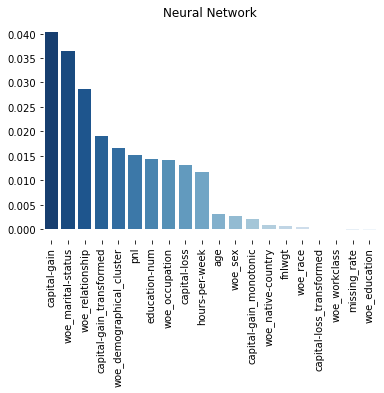

In [459]:
NN_plot=sns.barplot(x=list(importance_NN.keys()),y=list(importance_NN.values()), palette = 'Blues_r')
NN_plot.set_xticklabels(labels = importance_NN.keys(),rotation=90)
NN_plot.set_title("Neural Network")
sns.despine(left=True, bottom=True)
plt.show()


## LightGBM

In [424]:
def score(X, y):
    y_pred = class_tree.predict(X)
    return metrics_sk.roc_auc_score(y, y_pred)

base_score, score_decreases = get_score_importances(score, X_test_final.values, y_test_final)
feature_importances = np.mean(score_decreases, axis=0)
feature_importance_dict = {}
for i, feature_name in enumerate(feats):
    feature_importance_dict[feature_name]=feature_importances[i]
importance_lgbm = dict(sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)[:-1])

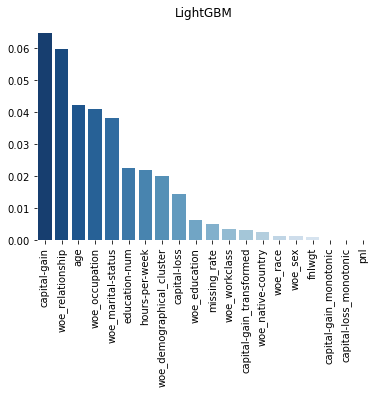

In [458]:
lgbm_plot=sns.barplot(x=list(importance_lgbm.keys()),y=list(importance_lgbm.values()), palette = 'Blues_r')
lgbm_plot.set_xticklabels(labels = importance_lgbm.keys(),rotation=90)
lgbm_plot.set_title("LightGBM")
sns.despine(left=True, bottom=True)
plt.show()

# Chosen Model: Stacking Naive Bayes

## Why?

## It resulted on the best choice between AUC, F1 and Accuracy. Once we're interested on the people that have a >50K income, it is important to have a good recall rate, and also be able to distinguish the events' distribution relative to the non-events'distribution.

## References:

#### SWISH: A SELF-GATED ACTIVATION FUNCTION
#### Missing value imputation using decision trees and decision forests by splitting and merging records: Two novel techniques
#### A PRIMER ON BOX-COX ESTIMATION 
#### Maximum expected F-measure training of logistic regression models.
#### Optimizing F-Measures: A Tale of Two Approaches
#### https://machinelearningmastery.com/stacking-ensemble-machine-learning-with-python/
#### Alternative Transformations to Handle Extreme Values of the Dependent Variable